<a href="https://colab.research.google.com/github/j-buss/wi-dpi-analysis/blob/development/eda/5.0_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Salary and Education in Wisconsin - 5.0 Analysis

### Prep

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [0]:
%matplotlib inline
plt.style.use('bmh')



### Functions



### Processing

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='wi-dpi-010'
landing_dataset_name='landing'
refined_dataset_name='refined'
gold_dataset_name='gold'

gold_person_tablename='person'
gold_person_role_tablename='person_role'

In [0]:
bq_client = bigquery.Client(project=project_id)

## Analysis

### Why are there 0 salaries?

In [0]:
sql='''
  SELECT
    *
  FROM
    {}.{}
'''.format('refined','2015_all_staff_report')

In [11]:
df = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173824 entries, 0 to 173823
Data columns (total 39 columns):
id_nbr                     173824 non-null int64
first_name                 173824 non-null object
last_name                  173824 non-null object
file_number                138678 non-null object
gender                     173824 non-null object
race_ethnicity             173824 non-null object
birth_year                 173824 non-null int64
high_degree_cd             104466 non-null object
high_degree_desc           104466 non-null object
year_session               173824 non-null object
contract_days              173824 non-null int64
local_exp                  103834 non-null float64
total_exp                  103834 non-null float64
salary                     173824 non-null float64
benefits                   173824 non-null float64
staff_category_cd          173823 non-null object
staff_category_desc        173823 non-null object
school_cd                  173824 non-

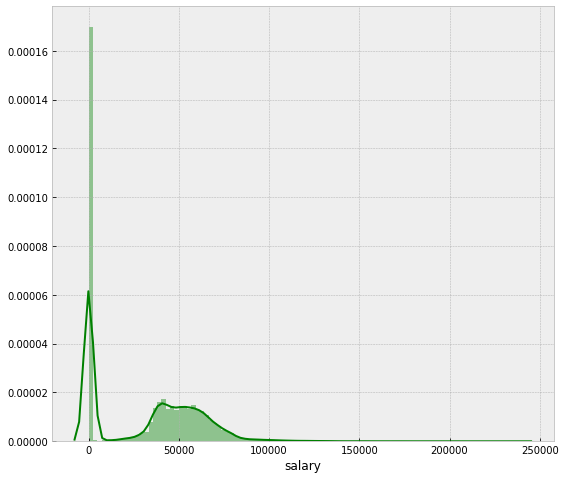

In [13]:
plt.figure(figsize=(9, 8))
sns.distplot(df['salary'], color='g', bins=100, hist_kws={'alpha': 0.4})

There are 69,990 individuals that work for the public schools that do not have salary data available. 


NEED TO FIND THE NUMBER OF INDIVIDUALS THAT DO HAVE SLAARY NOT JUST RECORDS.

ADD CHART FOR THE TYPES OF POSITIONS THAT DO NOT HAVE SALARY

In [59]:
print("Records without Salary: {}".format(df['salary'][df['salary']==0].count()))
print("Records with Salary: \t{}".format(df['salary'][df['salary']!=0].count()))
print("Total Records: \t\t{}".format(df['salary'].count()))

Records without Salary: 69990
Records with Salary: 	103834
Total Records: 		173824


In [0]:
#Same analysis but with SQL to verify
sql_salary_summary ='''
  SELECT
    sum(a.no_salary) as count_no_salary,
    sum(a.has_salary) as count_has_salary,
    count(*) as count_total_record
  FROM
    (SELECT
      CASE WHEN (salary = 0 OR salary is null) THEN 1
      ELSE 0
      END AS no_salary,
      CASE WHEN (salary <> 0 AND salary is not null) THEN 1
      ELSE 0
      END as has_salary
    FROM
      `wi-dpi-010.refined.2015_all_staff_report`) a
'''

So the people with 0 salary have 0 contract days and tend to be employees that are not under contract.

### How many people have a salary?

The following gives the number of records that have a salary. However, we must remember that the grain of the table is at person-role-school. So many individuals have multiple rows describing the many roles they fill.

In [64]:
df[df['salary']!=0].count()

id_nbr                     103834
first_name                 103834
last_name                  103834
file_number                103298
gender                     103834
race_ethnicity             103834
birth_year                 103834
high_degree_cd             103812
high_degree_desc           103812
year_session               103834
contract_days              103834
local_exp                  103834
total_exp                  103834
salary                     103834
benefits                   103834
staff_category_cd          103834
staff_category_desc        103834
school_cd                  103834
position_cd                103834
position_description       103769
position_type_cd           103769
position_type_desc         103769
assignment_area_cd         103834
assignment_area_desc       103810
low_grade_cd               103834
low_grade_desc             103834
high_grade_cd              103834
high_grade_desc            103834
assignment_fte              94781
school_name   

Let's filter that list by the max salary:

In [69]:
df[df['salary']!=0].groupby(['id_nbr','first_name','last_name'])['salary'].max().count()

72760

In [0]:
#with SQL
SELECT
  id_nbr,
  first_name,
  last_name,
  max(salary)
FROM
  `wi-dpi-010.refined.2015_all_staff_report`
GROUP BY 1, 2, 3
HAVING max(salary) > 0

This data has been saved into the gold.party_w_salary table.

In [0]:
sql='''
  SELECT
    *
  FROM
    {}.{}
'''.format('gold','party_w_salary')

In [72]:
df_party_w_salary = pd.read_gbq(sql, project_id=project_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


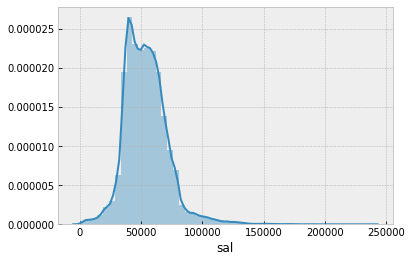

In [82]:
sns.distplot(df_party_w_salary['sal'],norm_hist=True)

### What are the factors that affect salary?

In [0]:
#Characteristics of the individual: Age, Experience, Gender, RaceEthnicity,
#Characteristics of their roles: FTE, Number of Roles, Teacher/Administrator, Subject, School, Cesa
#Create Linear Regression to predict the Salary of an individual